# Pokersters Fantasy Football Notebook
Lets do the data thang

In [102]:
# !pip install sleeper-api-wrapper
# !pip install matplotlib-label-lines

### Initialize

In [103]:
from sleeper_wrapper import League, Stats, Players
import pandas as pd
import numpy as np
import io
import csv
import re
import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from labellines import labelLine, labelLines

league_id = 723630813350014976
league = League(league_id)
players = Players()
# players_df = pd.read_pickle('./sleeper_players.pkl')
# ffa_proj_df = pd.read_pickle("./ffa_proj.pkl")

In [104]:
# import player projection data from spreadsheet
with open('sleeper_players.pkl', 'wb') as file:
    ffa_proj_df = pd.read_csv('ffa_all_week8_10-26-2021.txt', sep='\t', index_col=False)
    ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')
    ffa_proj_df['Player_Pos'] = ffa_proj_df['Player'] + ffa_proj_df['Position']
    # why is the abbr for vegas LVR rather than LV??? annoying
    ffa_proj_df['Team'].replace({'LVR': 'LV', 'JAC': 'JAX'}, inplace=True)
    # convert defense player names from common name to abbreviated to match sleeper
    ffa_proj_df.to_pickle('./ffa_proj.pkl')

ffa_proj_df.head()

<ipython-input-104-8c9998166a10>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')


,Player,Team,Position,Floor,Mean,Ceiling,SD,Risk,Drop Off,Tier,ADP,Player_Pos
0,Josh Allen,BUF,QB,24.400000,25.900000,27.200000,1.220000,2.510000,1.790000,1.000000,NaN,Josh AllenQB
1,Patrick Mahomes,KC,QB,23.000000,24.100000,25.300000,0.938000,3.500000,1.370000,2.000000,NaN,Patrick MahomesQB
2,Kyler Murray,ARI,QB,21.400000,22.700000,23.800000,1.130000,3.050000,0.746000,2.000000,NaN,Kyler MurrayQB
3,Jalen Hurts,PHI,QB,17.700000,21.900000,24.700000,2.860000,5.600000,0.742000,3.000000,NaN,Jalen HurtsQB
4,Justin Herbert,LAC,QB,20.500000,21.200000,21.600000,0.458000,4.460000,0.200000,3.000000,NaN,Justin HerbertQB


In [105]:
# Import players from sleeper, run this block to get updated players data
players_dict = players.get_all_players()
players_df = pd.DataFrame(players_dict).transpose()
players_df['full_name'] = players_df['full_name'].str.replace('.', '')
players_df['full_name_pos'] = players_df['full_name'] + players_df['position']
players_df = players_df.reset_index()
players_df = players_df.merge(ffa_proj_df, left_on='full_name_pos', right_on='Player_Pos', how='left')
players_df['player_id'] = players_df['index'].fillna(players_df['Team'])
players_df = players_df.set_index('player_id')
players_df = players_df.drop(columns=['index'])
for i in players_df.loc[players_df['fantasy_positions'].apply(lambda x: True if x and 'DEF' in x else False).tolist()].index.tolist():
    dst_matches = ffa_proj_df[(ffa_proj_df['Position'] == 'DST') & (ffa_proj_df['Team'] == i)]
    if not dst_matches.empty:
        players_df.loc[i, ffa_proj_df.columns] = dst_matches.iloc[0]
players_df[ffa_proj_df.columns] = players_df[ffa_proj_df.columns].fillna(0)
players_df.to_pickle('./sleeper_players.pkl')
players_df.head()

<ipython-input-105-fa3af1a1ef9c>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  players_df['full_name'] = players_df['full_name'].str.replace('.', '')


,last_name,weight,yahoo_id,swish_id,sportradar_id,team,rotowire_id,pandascore_id,injury_status,depth_chart_order,...,Position,Floor,Mean,Ceiling,SD,Risk,Drop Off,Tier,ADP,Player_Pos
player_id,,,,,,,,,,,,,,,,,,,,,
2103,Booth,285,27841,None,4cd4976e-e230-4935-ad3f-c12876a41350,None,9866,None,None,None,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6250,Bryant,,32538,None,9ff46edb-988f-4c8a-ad56-0502808ca1a6,None,None,None,NA,None,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4116,Garcia,293,30198,None,a2b6e1f9-1f06-45e3-b6e9-79ec8490e5ef,None,11794,None,None,None,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6177,Saunders,324,31916,831799,757c55e1-2f3a-41d2-a211-16bf577a1586,KC,13746,None,Questionable,2,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
5870,Jones,221,31838,879981,0042266b-cb28-4012-bfd2-06650badad97,NYG,13491,None,None,1,...,QB,17.500000,18.400000,20.000000,1.060000,5.420000,0.199000,6.000000,0.000000,Daniel JonesQB


In [106]:
ffa_proj_df.head()

,Player,Team,Position,Floor,Mean,Ceiling,SD,Risk,Drop Off,Tier,ADP,Player_Pos
0,Josh Allen,BUF,QB,24.400000,25.900000,27.200000,1.220000,2.510000,1.790000,1.000000,NaN,Josh AllenQB
1,Patrick Mahomes,KC,QB,23.000000,24.100000,25.300000,0.938000,3.500000,1.370000,2.000000,NaN,Patrick MahomesQB
2,Kyler Murray,ARI,QB,21.400000,22.700000,23.800000,1.130000,3.050000,0.746000,2.000000,NaN,Kyler MurrayQB
3,Jalen Hurts,PHI,QB,17.700000,21.900000,24.700000,2.860000,5.600000,0.742000,3.000000,NaN,Jalen HurtsQB
4,Justin Herbert,LAC,QB,20.500000,21.200000,21.600000,0.458000,4.460000,0.200000,3.000000,NaN,Justin HerbertQB


### Get Leaguemates data

In [107]:
users = league.get_users()
users_df = pd.DataFrame(users)
users_df = users_df.set_index(users_df.columns[0])
users_df

,settings,metadata,league_id,is_owner,is_bot,display_name,avatar
user_id,,,,,,,
375038190341611520,None,"{'team_name': 'The Trolley Problems', 'mention...",723630813350014976,None,False,thinkfast86,3c7def417a4613d104ae66403af0e0e7
607043401484926976,None,"{'team_name': 'Gaskin Dobbins', 'show_mascots'...",723630813350014976,None,False,mmasison,e36c64e702e2db846c91eb439a13df6a
608864437348163584,None,"{'team_name': 'Je Ne Saquon', 'mention_pn': 'o...",723630813350014976,None,False,TheVermanator,None
723630209273765888,None,"{'team_name': 'Hit Quads like Saquon', 'mentio...",723630813350014976,True,False,benslayer68,None
723633476015857664,None,"{'team_name': 'Tom Brady's Son', 'mention_pn':...",723630813350014976,None,False,dlaffs,6e0dc0a80e7d0560d8ef4777d3a90b16
723650381690769408,None,"{'team_name': '10,000 Rats', 'show_mascots': '...",723630813350014976,None,False,mikulis,ea2334c4e55f4c7d1d1544544eae3f54
723683736822059008,None,"{'mascot_item_type_id_leg_6': 'dogecoin', 'mas...",723630813350014976,None,False,schlaich,0008e9a0c13d1ebb16549afa8e884ef3
723753245457104896,None,"{'team_name': 'Questionably Mediocre ', 'menti...",723630813350014976,None,False,izzyfoshizzy8,15d7cf259bc30eab8f6120f45f652fb6
723755503108349952,None,"{'team_name': 'Mahomes’ Modern Life', 'mention...",723630813350014976,None,False,hunterm19,6c08fd9d771cdc622d9c57632a02aa6d


In [108]:
rosters = league.get_rosters()
rosters_df = pd.DataFrame(rosters)
# if someone doesn't have a team name, use username
rosters_df['team_name'] = rosters_df['owner_id'].apply(lambda x: users_df.loc[x]['metadata']['team_name'] if 'team_name' in users_df.loc[x]['metadata'] else users_df.loc[x]['display_name'])
rosters_df.head()

,taxi,starters,settings,roster_id,reserve,players,player_map,owner_id,metadata,league_id,co_owners,team_name
0,None,"[5870, 4663, 6813, 2216, 4068, 1466, 6786, 126...","{'wins': 10, 'waiver_position': 4, 'waiver_bud...",1,[4951],"[1266, 1466, 1992, 2216, 4068, 4663, 4881, 495...",None,723630209273765888,"{'streak': '1W', 'record': 'WWWWWLLLWWWWLW'}",723630813350014976,None,Hit Quads like Saquon
1,None,"[421, 4029, 7528, 538, 4039, 4531, 1535, 391, ...","{'wins': 11, 'waiver_position': 5, 'waiver_bud...",2,[5892],"[1535, 391, 4029, 4039, 421, 4217, 4531, 536, ...",None,375038190341611520,"{'streak': '4W', 'record': 'WWWLWWWLWLWWWW', '...",723630813350014976,None,The Trolley Problems
2,None,"[2306, 5980, 5122, 7601, 1825, 515, 4131, 5272...","{'wins': 5, 'waiver_position': 9, 'waiver_budg...",3,[6806],"[1034, 1339, 1825, 2306, 3199, 4131, 5122, 515...",None,607043401484926976,"{'streak': '4L', 'record': 'WWLWLLLLWWLLLL'}",723630813350014976,None,Gaskin Dobbins
3,None,"[167, 4035, 7567, 4981, 4983, 5022, 5846, 7042...","{'wins': 8, 'waiver_position': 7, 'waiver_budg...",4,[4273],"[1049, 1144, 167, 3209, 4035, 4273, 4962, 4981...",None,723633476015857664,"{'streak': '2W', 'record': 'LLWLWWWWLWLLWW'}",723630813350014976,None,Tom Brady's Son
4,None,"[6797, 4018, 4866, 1352, 5927, 5001, 5890, 650...","{'wins': 7, 'waiver_position': 6, 'waiver_budg...",5,[5038],"[1067, 1352, 2028, 3225, 4018, 4602, 4866, 495...",None,608864437348163584,"{'streak': '2W', 'record': 'LLLLWWWWLWLLWW'}",723630813350014976,None,Je Ne Saquon


In [109]:
for col in ['Floor','Mean','Ceiling','Risk']:
    rosters_df['Starters_' + col] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']][col]))

rosters_df['Starters_Variance'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['SD']**2))
rosters_df['Starters_SD'] = rosters_df['Starters_Variance']**(1/2)
rosters_df

,taxi,starters,settings,roster_id,reserve,players,player_map,owner_id,metadata,league_id,co_owners,team_name,Starters_Floor,Starters_Mean,Starters_Ceiling,Starters_Risk,Starters_Variance,Starters_SD
0,None,"[5870, 4663, 6813, 2216, 4068, 1466, 6786, 126...","{'wins': 10, 'waiver_position': 4, 'waiver_bud...",1,[4951],"[1266, 1466, 1992, 2216, 4068, 4663, 4881, 495...",None,723630209273765888,"{'streak': '1W', 'record': 'WWWWWLLLWWWWLW'}",723630813350014976,None,Hit Quads like Saquon,107.030000,115.460000,126.900000,33.940000,10.790202,3.284844
1,None,"[421, 4029, 7528, 538, 4039, 4531, 1535, 391, ...","{'wins': 11, 'waiver_position': 5, 'waiver_bud...",2,[5892],"[1535, 391, 4029, 4039, 421, 4217, 4531, 536, ...",None,375038190341611520,"{'streak': '4W', 'record': 'WWWLWWWLWLWWWW', '...",723630813350014976,None,The Trolley Problems,102.270000,119.130000,131.840000,45.330000,20.968700,4.579159
2,None,"[2306, 5980, 5122, 7601, 1825, 515, 4131, 5272...","{'wins': 5, 'waiver_position': 9, 'waiver_budg...",3,[6806],"[1034, 1339, 1825, 2306, 3199, 4131, 5122, 515...",None,607043401484926976,"{'streak': '4L', 'record': 'WWLWLLLLWWLLLL'}",723630813350014976,None,Gaskin Dobbins,54.080000,64.990000,74.020000,44.490000,15.839136,3.979841
3,None,"[167, 4035, 7567, 4981, 4983, 5022, 5846, 7042...","{'wins': 8, 'waiver_position': 7, 'waiver_budg...",4,[4273],"[1049, 1144, 167, 3209, 4035, 4273, 4962, 4981...",None,723633476015857664,"{'streak': '2W', 'record': 'LLWLWWWWLWLLWW'}",723630813350014976,None,Tom Brady's Son,96.680000,109.690000,124.600000,40.580000,23.804476,4.878983
4,None,"[6797, 4018, 4866, 1352, 5927, 5001, 5890, 650...","{'wins': 7, 'waiver_position': 6, 'waiver_budg...",5,[5038],"[1067, 1352, 2028, 3225, 4018, 4602, 4866, 495...",None,608864437348163584,"{'streak': '2W', 'record': 'LLLLWWWWLWLLWW'}",723630813350014976,None,Je Ne Saquon,89.940000,99.390000,108.020000,42.820000,9.084603,3.014068
5,None,"[4984, 4988, 5916, 5859, 7564, 5133, 1689, 466...","{'wins': 10, 'waiver_position': 8, 'waiver_bud...",6,[4034],"[1110, 1689, 2078, 2320, 2505, 4034, 4036, 466...",None,723650381690769408,"{'streak': '6W', 'record': 'LWWWWLLLWWWWWW', '...",723630813350014976,None,"10,000 Rats",103.190000,113.460000,122.770000,32.660000,10.915259,3.303825
6,None,"[3294, 6955, 3969, 2449, 2309, 3214, 6814, 143...","{'wins': 7, 'waiver_position': 12, 'waiver_bud...",7,[7543],"[1433, 2133, 2251, 2309, 24, 2449, 3214, 3294,...",None,723683736822059008,"{'streak': '1L', 'restrict_pn_scoring_starters...",723630813350014976,None,The Zany Zebras,91.480000,98.490000,107.650000,33.870000,6.683155,2.585180
7,None,"[96, 2431, 7561, 928, 1426, 4066, 5872, 6650, ...","{'wins': 5, 'waiver_position': 3, 'waiver_budg...",8,None,"[1426, 1476, 2168, 2431, 4066, 5872, 5906, 591...",None,723753245457104896,"{'streak': '1W', 'record': 'LLWWLLWWLLLLLW'}",723630813350014976,None,Questionably Mediocre,78.200000,90.940000,102.610000,36.800000,18.103542,4.254826
8,None,"[4046, 6790, 4137, 3321, 4037, 5857, 830, 1945...","{'wins': 7, 'waiver_position': 1, 'waiver_budg...",9,None,"[1264, 1945, 2460, 3242, 3321, 4037, 4046, 413...",None,723755503108349952,"{'streak': '1L', 'record': 'WWLLLWLWLLWWWL'}",723630813350014976,None,Mahomes’ Modern Life,88.110000,96.020000,101.220000,27.210000,4.582306,2.140632
9,None,"[6904, 3164, 6945, 5937, 1479, 7553, 4993, 783...","{'wins': 6, 'waiver_position': 11, 'waiver_bud...",10,[6820],"[1479, 2374, 2391, 3164, 4147, 4149, 4993, 593...",None,724012989333708800,"{'streak': '5L', 'restrict_pn_scoring_starters...",723630813350014976,None,Belichick Yo Self,87.760000,99.690000,110.290000,34.520000,16.260067,4.032377


In [110]:
plt.rcParams['figure.figsize'] = [30, 15]

In [111]:
players_df.loc[[x for x in rosters_df.iloc[11]['starters'] if x != '0']].loc[:, ['full_name', 'Mean']]

,full_name,Mean
player_id,,
5849,Kyler Murray,22.700000
3198,Derrick Henry,18.600000
4199,Aaron Jones,14.100000
6794,Justin Jefferson,14.700000
6819,Michael Pittman,11.700000
3271,Tyler Higbee,7.770000
5549,Darrel Williams,10.200000
17,Matt Prater,0.000000
CAR,NaN,5.910000


<AxesSubplot:xlabel='team_name'>

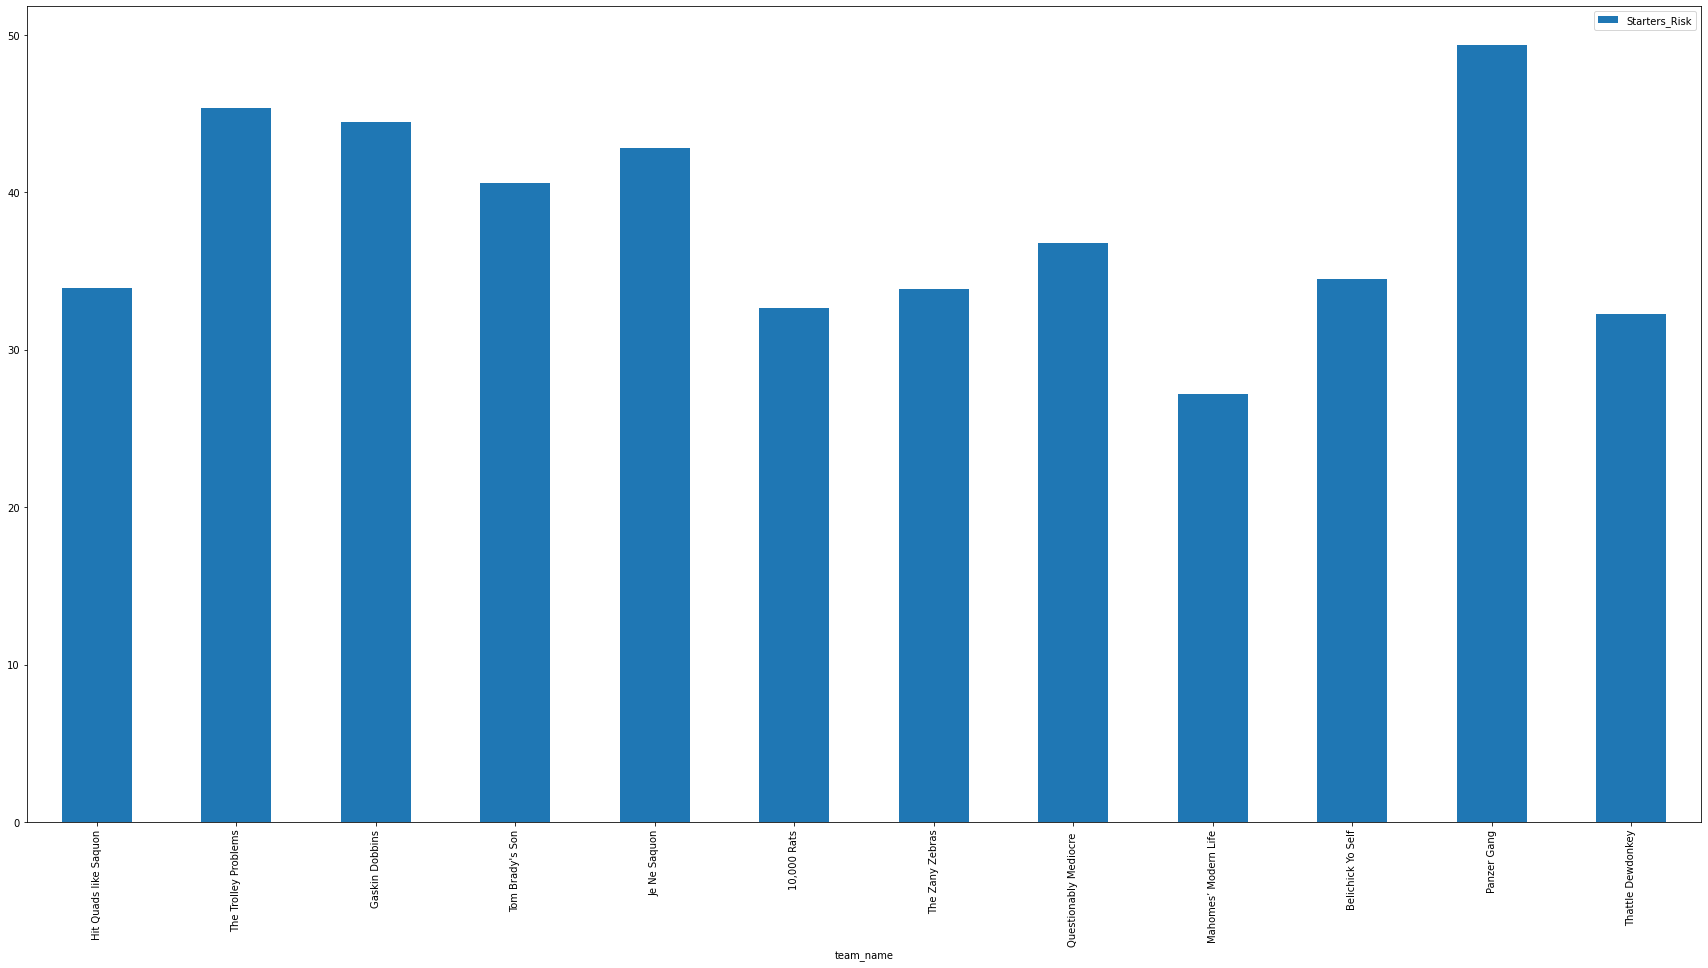

In [112]:
rosters_df.plot.bar(x='team_name', y='Starters_Risk')

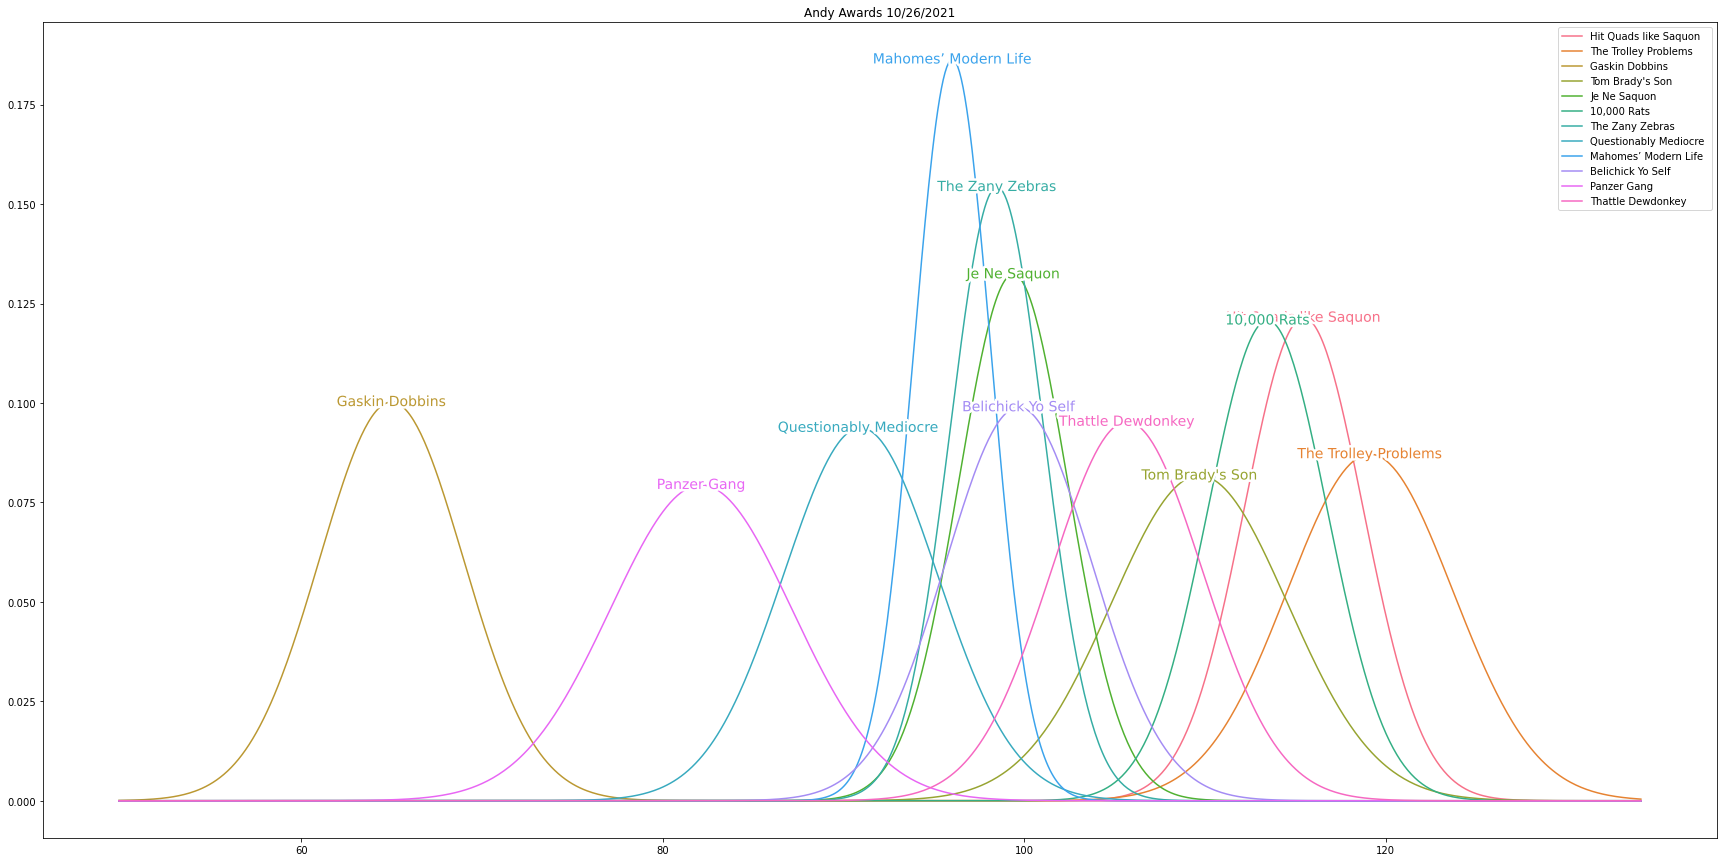

In [121]:
plt.rcParams['figure.figsize'] = [30, 15]
fig, ax1 = plt.subplots()
colors = sns.color_palette("husl", rosters_df.shape[0])
ax1.set_prop_cycle('color', colors)
x_axis = np.arange(rosters_df['Starters_Mean'].min() - 3*rosters_df['Starters_SD'].max(), rosters_df['Starters_Mean'].max() + 3*rosters_df['Starters_SD'].max(), .1)

for roster in rosters_df.iterrows():  
    plt.plot(x_axis, norm.pdf(x_axis, roster[1]['Starters_Mean'], roster[1]['Starters_SD']), label=roster[1]['team_name'])
    
labelLines(plt.gca().get_lines(), fontsize=14, align=True,  xvals = rosters_df['Starters_Mean'], zorder=2.5)
plt.legend()

ax1.title.set_text('Andy Awards 10/26/2021')
plt.show()

In [114]:
rosters_df.loc[:, ['team_name', 'Starters_Mean', 'Starters_SD']].sort_values(by='Starters_Mean')

,team_name,Starters_Mean,Starters_SD
2,Gaskin Dobbins,64.990000,3.979841
10,Panzer Gang,82.120000,5.025047
7,Questionably Mediocre,90.940000,4.254826
8,Mahomes’ Modern Life,96.020000,2.140632
6,The Zany Zebras,98.490000,2.585180
4,Je Ne Saquon,99.390000,3.014068
9,Belichick Yo Self,99.690000,4.032377
11,Thattle Dewdonkey,105.680000,4.187022
3,Tom Brady's Son,109.690000,4.878983
5,"10,000 Rats",113.460000,3.303825


In [115]:
rosters_df.loc[:, ['team_name', 'Starters_Ceiling', 'Starters_Floor']].sort_values(by='Starters_Floor')

,team_name,Starters_Ceiling,Starters_Floor
2,Gaskin Dobbins,74.020000,54.080000
10,Panzer Gang,96.090000,67.300000
7,Questionably Mediocre,102.610000,78.200000
9,Belichick Yo Self,110.290000,87.760000
8,Mahomes’ Modern Life,101.220000,88.110000
4,Je Ne Saquon,108.020000,89.940000
6,The Zany Zebras,107.650000,91.480000
11,Thattle Dewdonkey,115.540000,93.590000
3,Tom Brady's Son,124.600000,96.680000
1,The Trolley Problems,131.840000,102.270000


In [116]:
week = 8
matchups = league.get_matchups(week)
matchups_df = pd.DataFrame(matchups)

In [117]:
mu = matchups_df.groupby('matchup_id')

In [119]:
num_matchups = len(rosters_df) // 2

matchup_prob_df = pd.DataFrame()

pd.set_option('display.float_format', '{:.6f}'.format)

for i in range(1, num_matchups+1):
    p1, p2 = mu.get_group(i)['roster_id'].iloc[0] - 1, mu.get_group(i)['roster_id'].iloc[1] - 1
    d_mean = rosters_df.iloc[p1]['Starters_Mean'] - rosters_df.iloc[p2]['Starters_Mean']
    d_var = rosters_df.iloc[p1]['Starters_Variance'] + rosters_df.iloc[p2]['Starters_Variance']
    # victory_prob = (1 - norm(d_mean, d_var**(1/2)).cdf(0))
    victory_prob = (1 - norm(d_mean, d_var).cdf(0))
    row = {'team1': rosters_df.iloc[p1]['team_name'], 'team2': rosters_df.iloc[p2]['team_name'], 'victory_probability': victory_prob, 'd_mean': d_mean, 'd_var': d_var}
    matchup_prob_df = matchup_prob_df.append(row, ignore_index=True)

print(matchup_prob_df.loc[:, ['team1', 'team2', 'victory_probability']])

                    team1                 team2  victory_probability
0   Hit Quads like Saquon       Tom Brady's Son             0.566232
1    The Trolley Problems           10,000 Rats             0.570573
2       Belichick Yo Self           Panzer Gang             0.663947
3          Gaskin Dobbins          Je Ne Saquon             0.083761
4         The Zany Zebras     Thattle Dewdonkey             0.383259
5  Questionably Mediocre   Mahomes’ Modern Life             0.411407
